In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from datetime import datetime, timedelta

#funcao para criar os vetores de entrada e saida
def df_to_X_y2(df,window_size=5):
    df_as_numpy=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_numpy)-window_size):
        row=[a for a in df_as_numpy[i:i+window_size]]
        X.append(row)
        label=df_as_numpy[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

def plot_predictions3(model,X_sample,y):
    predictions=model.predict(X_sample).flatten()[1:].copy()
    df= pd.DataFrame(data={'Predictions':predictions,'Actuals':y[:-1]}).copy()
    plt.plot(df['Predictions']*oleo_std+oleo_mean,label='p')
    plt.plot(df['Actuals']*oleo_std+oleo_mean,label='a')
    plt.legend()
    plt.grid()
    return df, mse(y[:-1],predictions)

def fix_randoness():
    seed_value=42
    # Seed value
    # Apparently you may use different seed values at each stage

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)
    # for later versions: 
    # tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [2]:
#leitura do banco de dados
df=pd.read_csv('dados_unidos2.txt',sep='\t',decimal=',',encoding='UTF-8')
#Ajuste do nome das colunas
trocar_colunas={'Período': 'Data', 'Poço ANP':'Poco', 'Petróleo Equivalente (boe/d)':'boed',
           'Óleo (m3/d)':'oleo', 'Gás Natural (mil m3/d)':'gas', 'Água (m3/d)':'agua', 'Dias':'dias',
           'Potencial':'potencial'}
df=df.rename(columns=trocar_colunas)
#Calculando corte de água
df['BSW']=df['agua']/(df['agua']+df['oleo']+0.00000001)
#separando os poços no banco de dados para fazer o loop
dfs_pocos=[]
for i in df.Poco.unique():
    dfs_pocos.append([i,df[df.Poco==i]])



In [3]:
#vetor de eficiências de corte
eficiencias_escolha=[.2,.4,.6,.7,.8,.9]
list_previsao=[]
list_erros=[]
list_prev_poco={}
#loop nos poços
for j in dfs_pocos[:]:
    #loop nas eficiencias
    for ef_escolhida in eficiencias_escolha:
        #pegando o banco de dados
        df = j[1]
        #apenas para acompanhamento
        print(df.Poco.unique())
        print(ef_escolhida)
        #ajuste do formato da data
        df['Data']=pd.to_datetime(df.Data, format='%Y-%m-%d')
        #data para o index
        df.index=pd.to_datetime(df.Data, format='%Y-%m-%d')

        # Criar colunas de produção bruta e de óleo acumuladas em volume para normalizar o tempo
        df['mes'] = df.Data.apply(lambda x: x.days_in_month)
        df['tn']  = df['oleo']*df['mes']/1000000
        df['tn_2']= (df['oleo']+df['agua'])*df['mes']/1000000
        df['tn']  = df['tn'].cumsum()
        df['tn_2']= df['tn_2'].cumsum()
        # Calcular o BSW
        df['BSW']=df['agua']/(df['agua']+df['oleo']+0.0001)
        #separando o banco de dados para teste
        df_prev=df[-12:].copy()
        #separando o vector de eficiências e dias do teste para pós processamento
        vector_ef=df_prev['ef']
        vector_dias_mes=df_prev['mes']
        #retirando valores de produção nulos
        df=df[df.oleo>0]
        
        # separando os dados que serão utilizados para treino e validação
        df=df[:-12]
        # Achar o último bsw para estimar a bruta na estimativ
        bsw_median=df[-7:].BSW.median()
        #filtrando as eficiências
        df=df[df.ef>ef_escolhida]
        oleo=df[['oleo','tn_2']]
        tamanho_dados_entrada=len(oleo.columns)
        #definindo quantidade de intervalos no vetor de entrada nesse caso são 3 periodos
        WINDOW_SIZE=3
        X, y = df_to_X_y2(oleo,window_size=WINDOW_SIZE)
        X.shape, y.shape
        n1=24
        n2=0
        n3=y.shape[0]
        delta_a=n3-n1
        delta_b=n3-n2
        X_train, y_train = X[:delta_a], y[:delta_a]
        X_val, y_val = X[delta_a:], y[delta_a:]
        #normalizar o dado com os valores do treino
        oleo_mean = np.mean(X_train[:, :, 0])
        oleo_std = np.std(X_train[:, :, 0])
        ef_mean = np.mean(X_train[:, :, 1])
        ef_std = np.std(X_train[:, :, 1])

        def preprocess(Xd):
            Xd[:, :, 0] = (Xd[:, :, 0] - oleo_mean) / oleo_std 
            Xd[:, :, 1] = (Xd[:, :, 1] - ef_mean) / ef_std
            return Xd

        preprocess(X_train)
        preprocess(X_val)
        #preprocess(X_test)

        def preprocess_output(y):
            y[:] = (y[:] - oleo_mean) / oleo_std
            return y

        y_train=preprocess_output(y_train)
        y_val=preprocess_output(y_val)
        #roda a função para forçar a semente
        fix_randoness()
        #limpo as variaveis, provavelmente não é necessário
        model4=0
        cp4=0
        #cria um modelo
        model4=Sequential()
        model4.add(InputLayer((WINDOW_SIZE,tamanho_dados_entrada)))
        model4.add(LSTM(64))
        model4.add(Dense(1,'linear'))
        #model4.summary()
        #é possível salvar o melhor modelo
        #pasta='model'+j[0].split('-')[2]+'_'+str(ef_escolhida)+'/'
        #cp4=ModelCheckpoint(pasta,save_best_only=True)
        model4.compile(loss=MeanSquaredError(),optimizer='Adam', metrics=[RootMeanSquaredError()])
        #verbose vai te mostrar mais detalhes do ajuste, 0 vem menos informações
        model4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=25,verbose=0)
        
        #inicia o tratamento para gerar as estimativas do vetor de teste
        test_predictions=[]
        first_value=X_val[-1,1:,:].reshape(WINDOW_SIZE*2-2)
        ultimo_bp=df.tn_2.max()
        oleo_ultimo=(oleo.oleo[-1]-oleo_mean)/oleo_std
        tn_ultimo=(oleo.tn_2[-1]-ef_mean)/ef_std
        first_value=np.append(first_value,oleo_ultimo)
        #basicamente é para acrescentar o ultimo ponto da parte de validação
        first_value=np.append(first_value,tn_ultimo).reshape(1,WINDOW_SIZE,2)
        #o loop aqui é 12, pois temos 12 valores no teste, caso haja necessidade pode-se aumentar
        for i in range(12):
            #gera predicao
            current_pred=model4.predict(first_value)
            #salva predicao
            test_predictions.append(current_pred.reshape(1)[0])
            #estimar o vetor de tempo normalizado, que é integral da vazão bruta, por isso o bsw_median foi salvo
            current_pred=current_pred.reshape(1)
            current_pred2=(current_pred*oleo_std+oleo_mean)*vector_ef[i]*vector_dias_mes[i]/(1-bsw_median)/1000000
            ultimo_bp=(ultimo_bp+current_pred2[0])
            ultimo_bp_trans=(ultimo_bp-ef_mean)/ef_std
            #realimenta a saida na entrada
            first_value=np.append(first_value[:,1:,:].reshape(4),current_pred)
            first_value=np.append(first_value,ultimo_bp_trans).reshape(1,3,2)

        #pós processa as predições
        for i in range(len(test_predictions)):
            test_predictions[i]=(test_predictions[i]*oleo_std+oleo_mean)*vector_ef[i]
        
        #salva as informações para gerar gráficos e fazer análises
        list_previsao.append([j[0],ef_escolhida,test_predictions])
        list_erros.append([j[0], MAPE((df_prev['oleo']).values,np.array(test_predictions)),ef_escolhida,mse((df_prev['oleo']).values,np.array(test_predictions), squared=True)])
    list_previsao.append([j[0],'prev',(df_prev['oleo']).values])
print('pronto!')

['7-RO-46HP-RJS']
0.2




1/1 [==============================] - 0s 17ms/step
['7-RO-46HP-RJS']
0.4
1/1 [==============================] - 0s 21ms/step
['7-RO-46HP-RJS']
0.6
1/1 [==============================] - 0s 16ms/step
['7-RO-46HP-RJS']
0.7
1/1 [==============================] - 0s 29ms/step
['7-RO-46HP-RJS']
0.8
1/1 [==============================] - 0s 18ms/step
['7-RO-46HP-RJS']
0.9
1/1 [==============================] - 0s 15ms/step
['7-RO-50HPA-RJS']
0.2
1/1 [==============================] - 0s 24ms/step
['7-RO-50HPA-RJS']
0.4
1/1 [==============================] - 0s 16ms/step
['7-RO-50HPA-RJS']
0.6
1/1 [==============================] - 0s 18ms/step
['7-RO-50HPA-RJS']
0.7
1/1 [==============================] - 0s 16ms/step
['7-RO-50HPA-RJS']
0.8
1/1 [==============================] - 0s 17ms/step
['7-RO-50HPA-RJS']
0.9
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
['7-RO-60HP-RJS']
0.2
1/1 [==============================] - 0s 18ms/step
['7-RO-60HP-RJS']
0.4
1/1 [==============================] - 0s 17ms/step
['7-RO-60HP-RJS']
0.6
1/1 [==============================] - 0s 16ms/step
['7-RO-60HP-RJS']
0.7
1/1 [==============================] - 0s 16ms/step
['7-RO-60HP-RJS']
0.8
1/1 [==============================] - 0s 16ms/step
['7-RO-60HP-RJS']
0.9
1/1 [==============================] - 0s 16ms/step
['7-RO-62HP-RJS']
0.2
1/1 [==============================] - 0s 17ms/step
['7-RO-62HP-RJS']
0.4
1/1 [==============================] - 0s 17ms/step
['7-RO-62HP-RJS']
0.6
1/1 [==============================] - 0s 22ms/step
['7-RO-62HP-RJS']
0.7
1/1 [==============================] - 0s 16ms/step
['7-RO-62HP-RJS']
0.8
1/1 [==============================] - 0s 17ms/step
['7-RO-62HP-RJS']
0.9
1/1 [==============================] - 0s 16ms/step
['7-RO-63HA-RJS']
0.2


1/1 [==============================] - 0s 23ms/step
['7-RO-63HA-RJS']
0.4
1/1 [==============================] - 0s 17ms/step
['7-RO-63HA-RJS']
0.6
1/1 [==============================] - 0s 16ms/step
['7-RO-63HA-RJS']
0.7
1/1 [==============================] - 0s 24ms/step
['7-RO-63HA-RJS']
0.8
1/1 [==============================] - 0s 16ms/step
['7-RO-63HA-RJS']
0.9
1/1 [==============================] - 0s 16ms/step
['7-RO-72HPB-RJS']
0.2
1/1 [==============================] - 0s 16ms/step
['7-RO-72HPB-RJS']
0.4
1/1 [==============================] - 0s 17ms/step
['7-RO-72HPB-RJS']
0.6
1/1 [==============================] - 0s 20ms/step
['7-RO-72HPB-RJS']
0.7
1/1 [==============================] - 0s 17ms/step
['7-RO-72HPB-RJS']
0.8
1/1 [==============================] - 0s 18ms/step
['7-RO-72HPB-RJS']
0.9
1/1 [==============================] - 0s 16ms/step
['7-RO-74HP-RJS']
0.2
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
['7-RO-74HP-RJS']
0.4
1/1 [==============================] - 0s 17ms/step
['7-RO-74HP-RJS']
0.6
1/1 [==============================] - 0s 15ms/step
['7-RO-74HP-RJS']
0.7
1/1 [==============================] - 0s 20ms/step
['7-RO-74HP-RJS']
0.8
1/1 [==============================] - 0s 21ms/step
['7-RO-74HP-RJS']
0.9
1/1 [==============================] - 0s 21ms/step
['8-RO-58HP-RJS']
0.2
1/1 [==============================] - 0s 19ms/step
['8-RO-58HP-RJS']
0.4
1/1 [==============================] - 0s 16ms/step
['8-RO-58HP-RJS']
0.6
1/1 [==============================] - 0s 17ms/step
['8-RO-58HP-RJS']
0.7
1/1 [==============================] - 0s 16ms/step
['8-RO-58HP-RJS']
0.8
1/1 [==============================] - 0s 16ms/step
['8-RO-58HP-RJS']
0.9
1/1 [==============================] - 0s 17ms/step
['7-RO-135H-RJS']
0.2
1/1 [==============================] - 0s 16ms/step
['7-RO-135H-RJS']
0.4
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step
['7-RO-135H-RJS']
0.6
1/1 [==============================] - 0s 24ms/step
['7-RO-135H-RJS']
0.7
1/1 [==============================] - 0s 16ms/step
['7-RO-135H-RJS']
0.8
1/1 [==============================] - 0s 16ms/step
['7-RO-135H-RJS']
0.9
1/1 [==============================] - 0s 17ms/step
pronto!


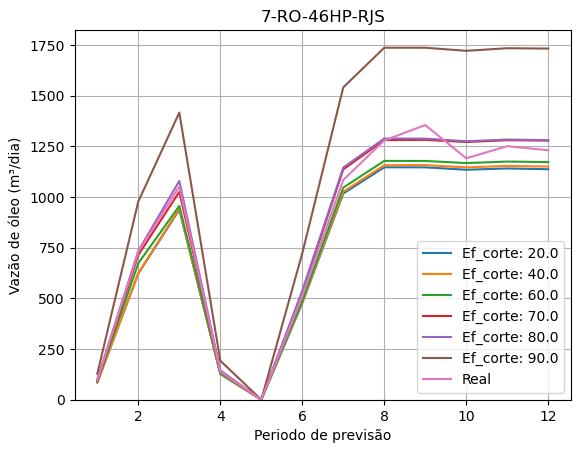

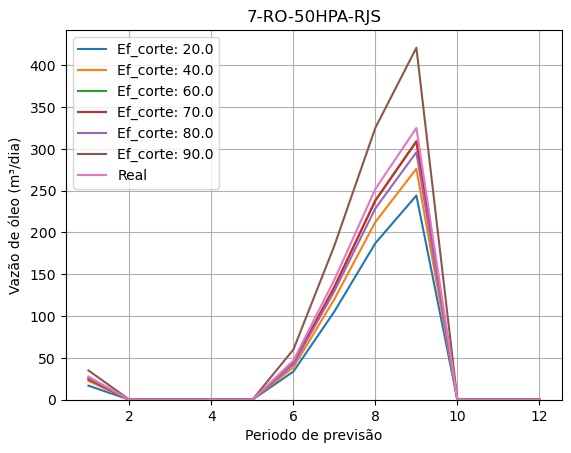

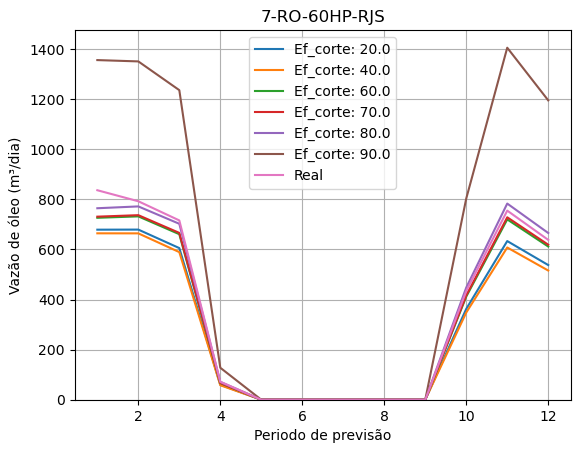

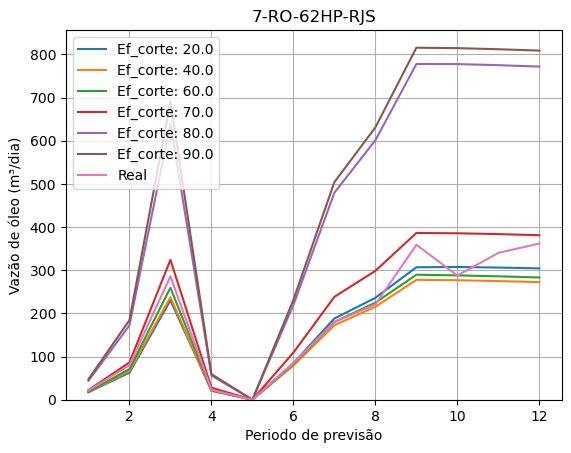

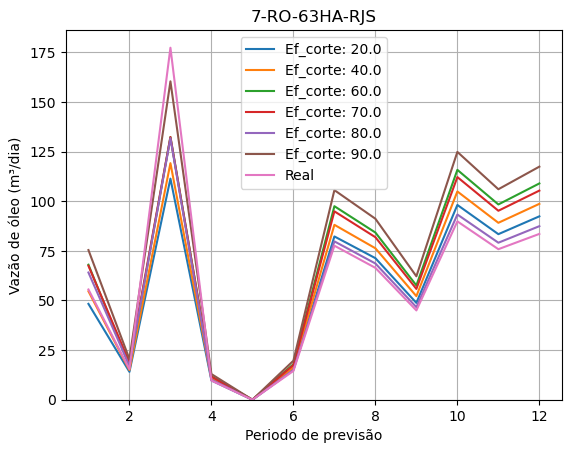

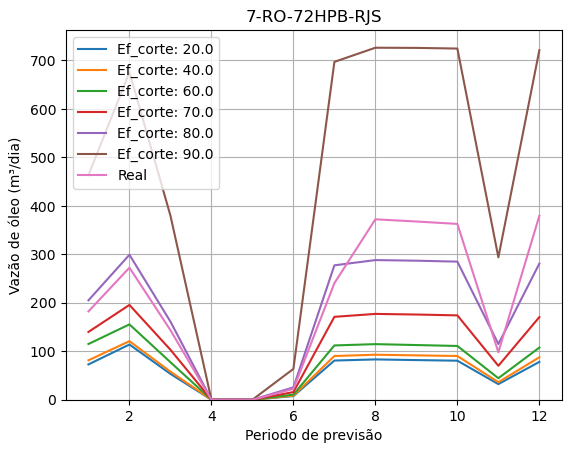

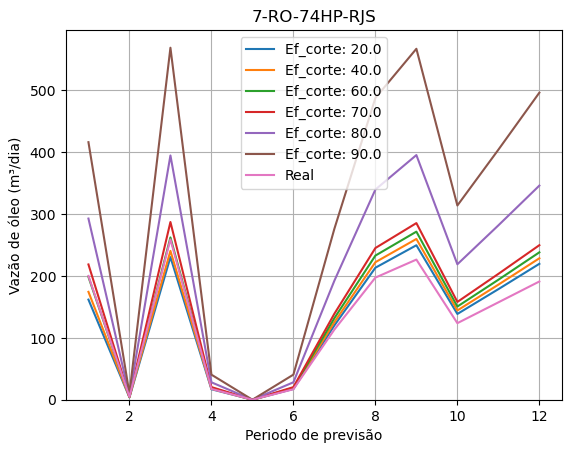

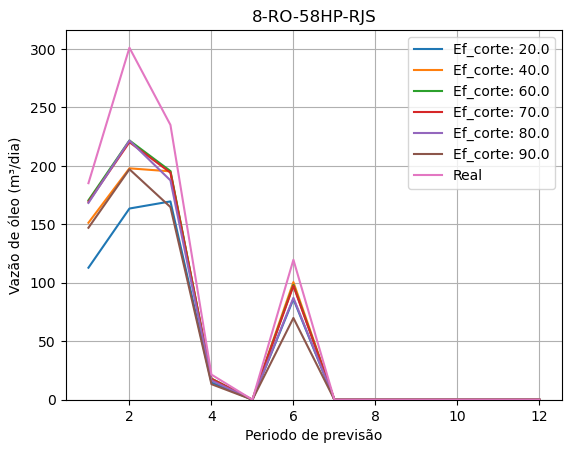

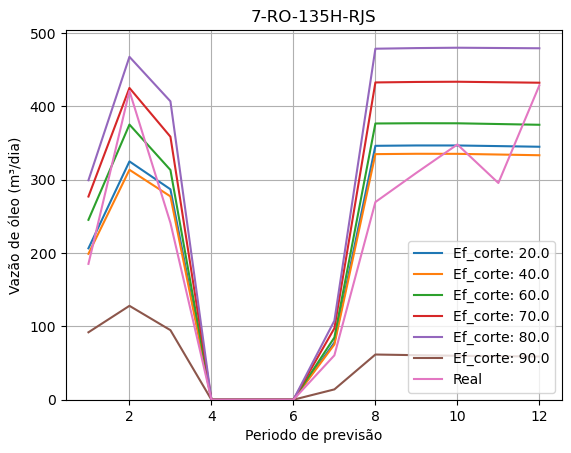

<Figure size 640x480 with 0 Axes>

In [15]:

#df_prev
a=pd.DataFrame(list_previsao)
dados_exportar_test=[]
for i in a[0].unique():
    #plt.figure(figsize=(8,6),dpi=1200)
    b = a[a[0]==i]
    #print(b)
    for index, j in b.iterrows():
        if j[1] == 'prev':
            plt.plot(list(range(1,len(j[2])+1)),j[2],label='Real')
            for k,z in enumerate(j[2]):
                dados_exportar_test.append([i,k,z,'Real'])
        else:
            plt.plot(list(range(1,len(j[2])+1)),j[2],label='Ef_corte: '+str(j[1]*100))
            for k,z in enumerate(j[2]):
                dados_exportar_test.append([i,k,z,str(j[1]*100)])
    plt.ylabel('Vazão de óleo (m³/dia)')
    plt.xlabel('Periodo de previsão')
    plt.ylim(0)
    plt.title(i)
    plt.grid()
    plt.legend()
    plt.show()
    #plt.savefig(i+'.jpeg',dpi=1200)
    plt.clf()

In [16]:
pd.DataFrame(dados_exportar_test,columns=['Poco','periodo','valor','evento']).to_csv('dados_vazao_plotar.txt',sep='\t',decimal=',',index=None)

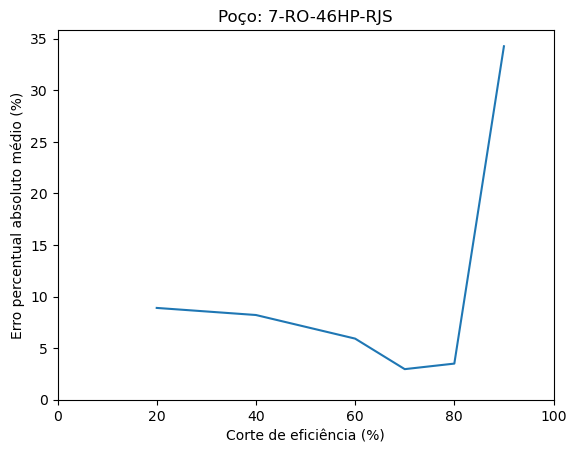

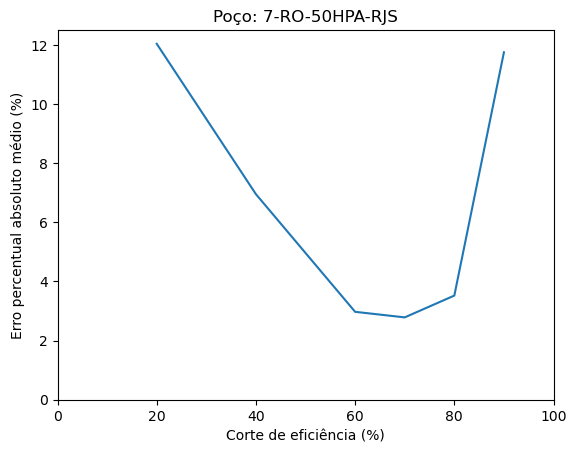

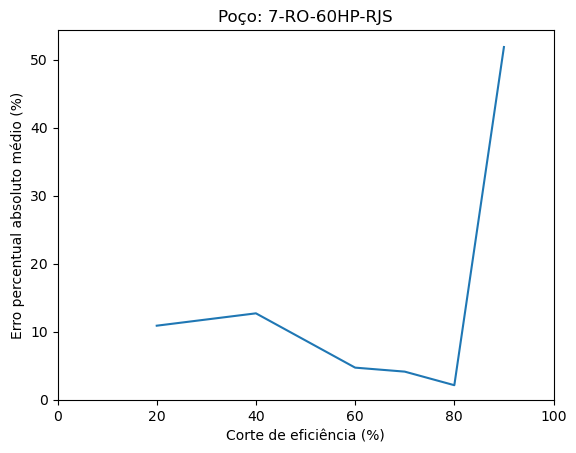

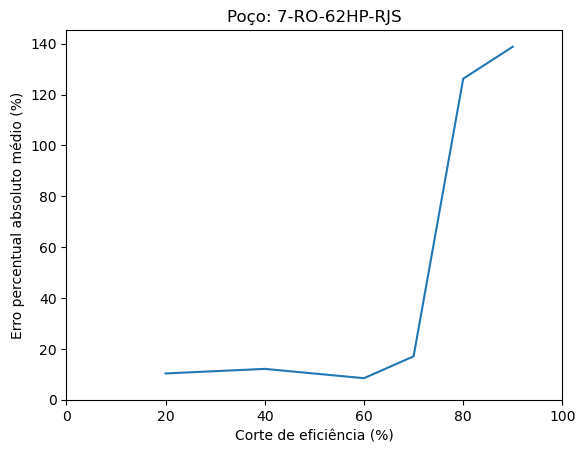

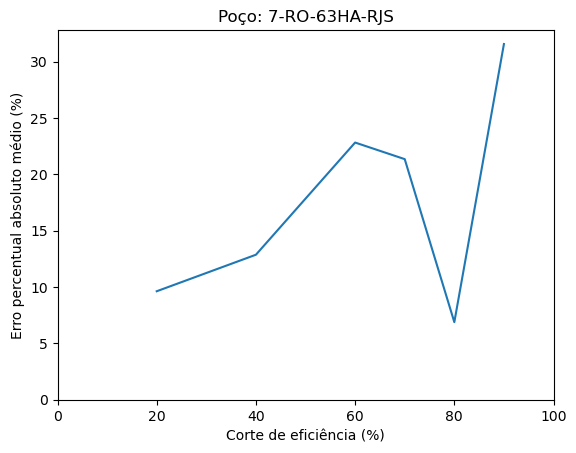

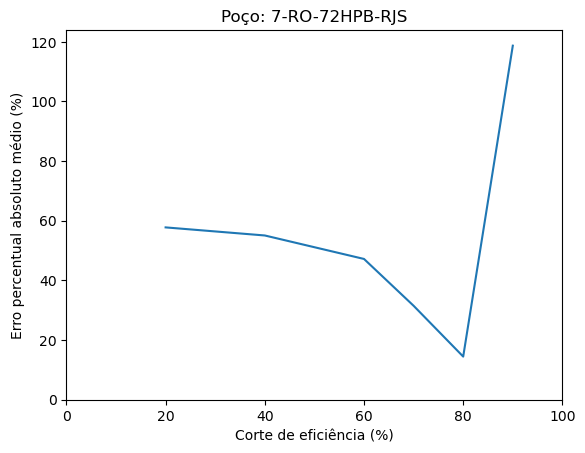

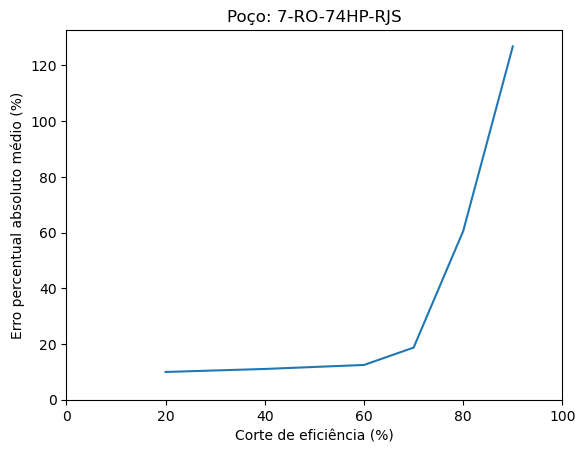

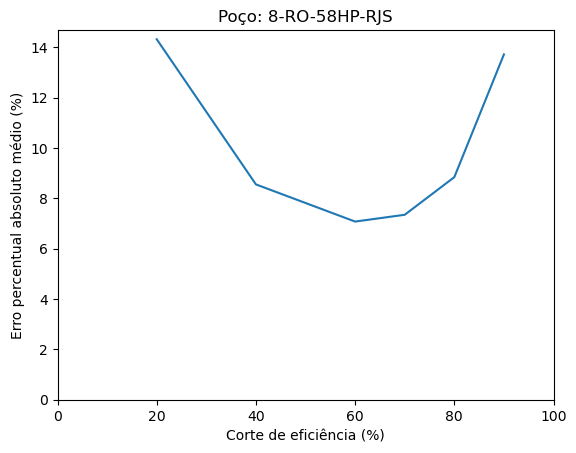

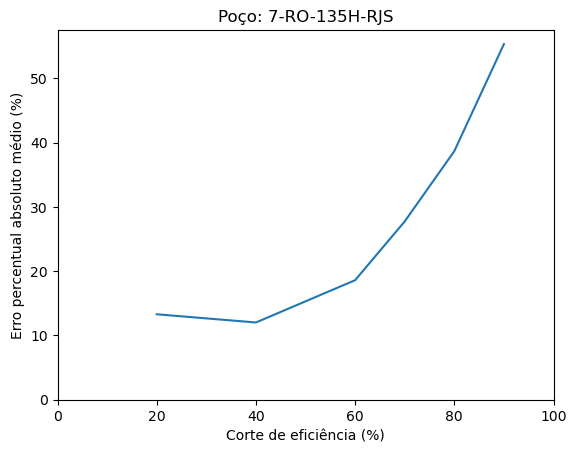

<Figure size 640x480 with 0 Axes>

In [7]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])
a
for i in a.poco.unique():
    #plt.figure(figsize=(8,6),dpi=1200)
    filtro=a.poco==i
    #plt.plot(a[filtro][1],a[filtro][2]/a[filtro][2].max())
    plt.plot(a[filtro].ef*100,a[filtro].mape*100)
    plt.title('Poço: '+i)
    plt.xlabel('Corte de eficiência (%)')
    plt.ylabel('Erro percentual absoluto médio (%)')
    plt.xlim(0,100)
    plt.ylim(0)
    #plt.grid()
    plt.show()
    #plt.savefig(i+'.jpeg',dpi=1200)
    plt.clf()


In [28]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])
pd.pivot_table(a,index='poco',columns='ef',values='mape')
pd.pivot_table(a,index='poco',values='mape',aggfunc='min').reset_index().mape.mean()

0.07416414070222394

In [22]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])
#a.to_csv('lista_erros.txt',sep='\t',decimal=',',index=None)
b=pd.pivot_table(a,index='poco',values='mape',aggfunc='min').reset_index()
b=b.merge(a,how='left', on=['poco','mape']).drop_duplicates(subset='mape')
b
a=pd.DataFrame(list_previsao,columns=['poco','ef','previsao'])
c=a[a.ef=='prev'].copy()
a=a[a.ef!='prev']
b=b.merge(a,on=['poco','ef'],how='left')
b['previsao']=b['previsao'].apply(lambda x: np.array(x))
b.previsao.sum()

c['previsao']=c['previsao'].apply(lambda x: np.array(x))
#pd.DataFrame(c.previsao.sum())



In [23]:
#pd.DataFrame(b.previsao.sum())

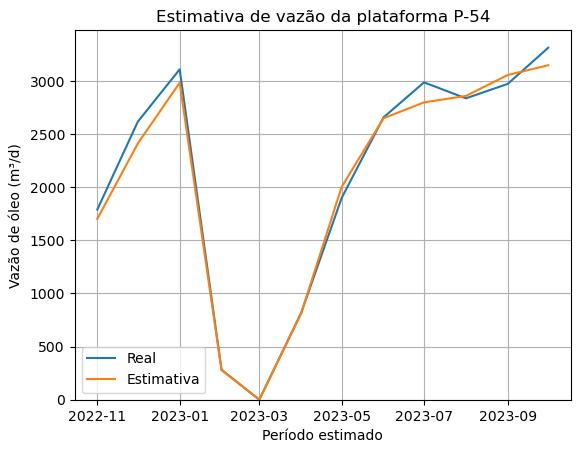

12223.894011124277

<Figure size 640x480 with 0 Axes>

In [24]:
#plt.figure(figsize=(8,6),dpi=1200)
c_real=c.previsao.sum()
b_estimativa=b.previsao.sum()
plt.plot(pd.to_datetime(dfs_pocos[0][1].Data[-12:],format='%Y-%m-%d'),c_real,label='Real')
plt.plot(pd.to_datetime(dfs_pocos[0][1].Data[-12:],format='%Y-%m-%d'),b_estimativa,label='Estimativa')
plt.ylabel('Vazão de óleo (m³/d)')
plt.xlabel('Período estimado')
plt.title('Estimativa de vazão da plataforma P-54')
plt.grid()
plt.ylim(0)
plt.legend()
plt.show()
#plt.savefig('Plataforma.jpeg',dpi=1200)
plt.clf()
mse(c.previsao.sum(),b.previsao.sum())

In [12]:
MAPE(c.previsao.sum(),b.previsao.sum())

0.032412297629139684

In [27]:
pd.DataFrame({'real':c.previsao.sum(),'estimado':b.previsao.sum()})

,real,estimado
0,1790.51,1702.931620
1,2617.67,2412.399610
2,3110.04,2984.371172
3,282.01,279.497420
4,0.00,0.000000
5,818.04,813.533209
6,1899.94,2004.207667
7,2657.76,2649.490134
8,2987.58,2799.355902
9,2837.16,2859.594942


array([1790.51, 2617.67, 3110.04,  282.01,    0.  ,  818.04, 1899.94,
       2657.76, 2987.58, 2837.16, 2973.21, 3313.65])

In [13]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])



In [14]:
MAPE([1],[1.2])

0.19999999999999996

In [76]:
df=pd.read_csv('dados_unidos2.txt',sep='\t',decimal=',',encoding='UTF-8')
trocar_colunas={'Período': 'Data', 'Poço ANP':'Poco', 'Petróleo Equivalente (boe/d)':'boed',
           'Óleo (m3/d)':'oleo', 'Gás Natural (mil m3/d)':'gas', 'Água (m3/d)':'agua', 'Dias':'dias',
           'Potencial':'potencial'}
df=df.rename(columns=trocar_colunas)
df['BSW']=df['agua']/(df['agua']+df['oleo']+0.00000001)
#print(df.head)
#df=df[df.agua>0.1]
df['Data']=pd.to_datetime(df['Data'])
df=df[df.Data>='2022-10-01']

unir=pd.pivot_table(a,index='poco',values='mape',aggfunc='min').reset_index()

In [80]:
unir2=pd.pivot_table(df,index='Poco',values='ef',aggfunc='mean').reset_index()
unir2['poco']=unir2['Poco']

In [81]:
unir.merge(unir2,on='poco')

,poco,mape,Poco,ef
0,7-RO-135H-RJS,0.126855,7-RO-135H-RJS,0.702426
1,7-RO-46HP-RJS,0.029468,7-RO-46HP-RJS,0.666539
2,7-RO-50HPA-RJS,0.025007,7-RO-50HPA-RJS,0.190141
3,7-RO-60HP-RJS,0.021205,7-RO-60HP-RJS,0.482966
4,7-RO-62HP-RJS,0.079594,7-RO-62HP-RJS,0.613592
5,7-RO-63HA-RJS,0.071930,7-RO-63HA-RJS,0.491452
6,7-RO-72HPB-RJS,0.149529,7-RO-72HPB-RJS,0.617117
7,7-RO-74HP-RJS,0.095990,7-RO-74HP-RJS,0.261454
8,8-RO-58HP-RJS,0.051347,8-RO-58HP-RJS,0.322748


In [106]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2022-11-01 to 2023-10-01
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              12 non-null     datetime64[ns]
 1   Campo             12 non-null     object        
 2   Poco              12 non-null     object        
 3   boed              12 non-null     float64       
 4   oleo              12 non-null     float64       
 5   gas               12 non-null     float64       
 6   agua              12 non-null     float64       
 7   dias              12 non-null     float64       
 8   potencial         12 non-null     float64       
 9   ef                12 non-null     float64       
 10  Potencial (m³/d)  0 non-null      float64       
 11  BSW               12 non-null     float64       
 12  mes               12 non-null     int64         
 13  tn                12 non-null     float64       
 14  tn_2    

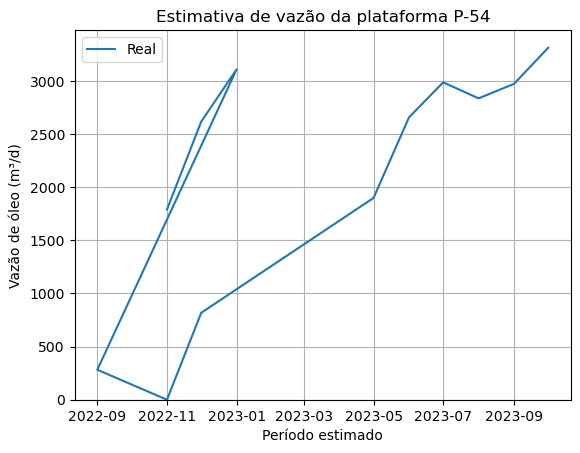

9935.142801823307

<Figure size 640x480 with 0 Axes>

In [103]:
daods_plot=pd.DataFrame({'Data':df_prev.Data.values,'Oleo_e':b_estimativa,'Oleo_r':c_real})

#plt.figure(figsize=(8,6),dpi=1200)

plt.plot(daods_plot.Data,daods_plot.Oleo_r,label='Real')
#plt.plot(b_estimativa,label='Estimativa')
plt.ylabel('Vazão de óleo (m³/d)')
plt.xlabel('Período estimado')
plt.title('Estimativa de vazão da plataforma P-54')
plt.grid()
plt.ylim(0)
plt.legend()
plt.show()
#plt.savefig('Plataforma.jpeg',dpi=1200)
plt.clf()
mse(c.previsao.sum(),b.previsao.sum())

167   2023-01-01
168   2023-02-01
169   2023-03-01
170   2023-04-01
171   2023-05-01
172   2023-06-01
173   2023-07-01
174   2023-08-01
175   2023-09-01
176   2023-10-01
Name: Data, dtype: datetime64[ns]